In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rlway import OSRD
OSRD.use_cases

['c1',
 'c1y2',
 'c2x2',
 'c2xx2',
 'c2y13s',
 'c2y1y2',
 'c2z2z2',
 'c3y1',
 'c3yy1yy3',
 'cvg_dvg',
 'point_switch',
 'station_capacity2',
 'straight_line']

In [3]:
use_case='cvg_dvg'
sim = OSRD(use_case=use_case, dir='tmp')

[11:25:59,943] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[11:25:59,992] [INFO]              [FullInfra] parsing infra
[11:26:00,080] [INFO]              [FullInfra] adaptation to kotlin
[11:26:00,117] [INFO]              [FullInfra] loading signals
[11:26:00,127] [INFO]              [FullInfra] building blocks
[11:26:00,132] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/simulation.json
[11:26:00,149] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.0
[11:26:00,212] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.1
[11:26:00,221] [INFO]  [StandaloneSimulationCommand] All simulations completed
[11:26:00,221] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/results.json


In [4]:
from rlway.schedules import schedule_from_osrd

0                       1            
                            s           e           s           e
D0<->buffer_stop.0        0.0   49.271387         NaN         NaN
CVG                 25.290046   53.626722  125.290046  153.626722
D2<->D3             32.871583   96.466092  132.871583  197.099453
D1<->buffer_stop.1        NaN         NaN       100.0  149.271387
DVG                 73.617113  108.066092  173.658637   209.36612
D4<->buffer_stop.2  78.205627  121.066092         NaN         NaN
D5<->buffer_stop.3        NaN         NaN  178.304105  220.699453

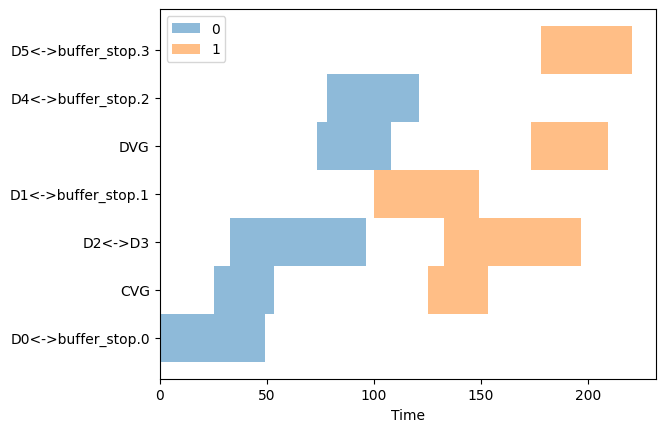

In [5]:
s = schedule_from_osrd(sim, eco_or_base='base')
ax = s.plot()
# ax.invert_yaxis()
# ax.legend('')
s.df

In [6]:
s.draw_graph()

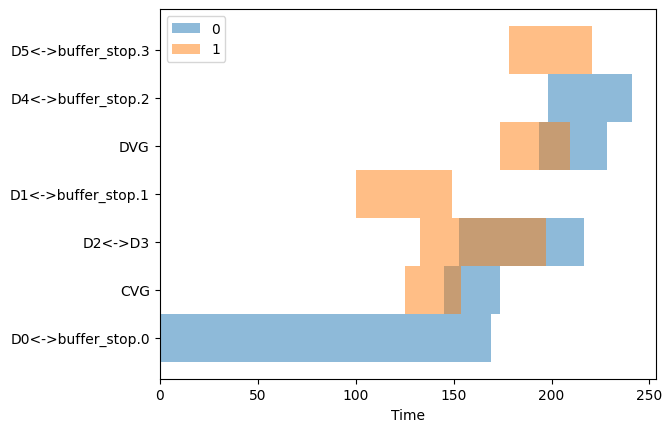

In [7]:
# sim = use_case_station_capacity2
sim.reset_delays()
sim.add_delay('train0', time_threshold=10, delay=120.)
delayed = sim.delayed()

s = schedule_from_osrd(delayed, eco_or_base='base')
ax = s.plot()

In [8]:
from rlway.scheduler_agent import SchedulerAgent
import pandas as pd
from dataclasses import dataclass

In [17]:

class DummySchedulerAgent(SchedulerAgent):
    @property
    def steps_extra_delays(self) -> pd.DataFrame:
        """As an example, make train1 stop 60s more at station"""
        extra_delays = self.initial_schedule.durations * 0.
        extra_delays.iloc[3][1] = 60.
        return extra_delays

@dataclass
class AddStop(SchedulerAgent):
    train: int = 0
    zone: str = ""
    duration: float = 0.

    @property
    def steps_extra_delays(self) -> pd.DataFrame:
        """Make the train stop at the given position for the given duration"""
        extra_delays = self.initial_schedule.durations * 0.
        extra_delays.loc[self.zone][self.train] = self.duration

        return extra_delays


<Axes: xlabel='Time'>

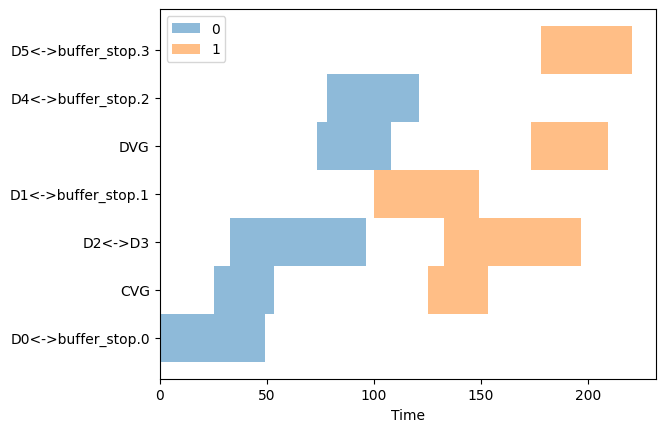

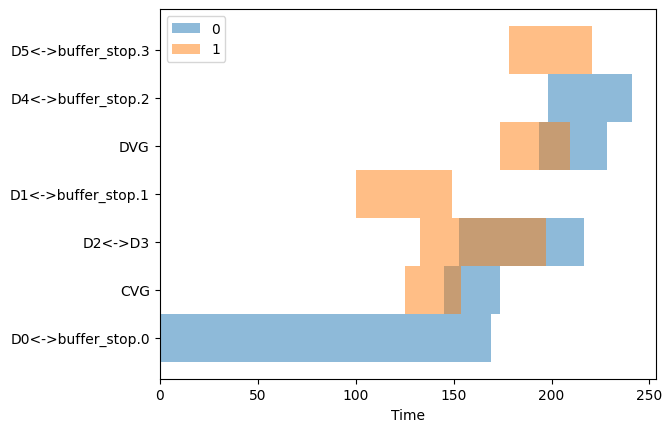

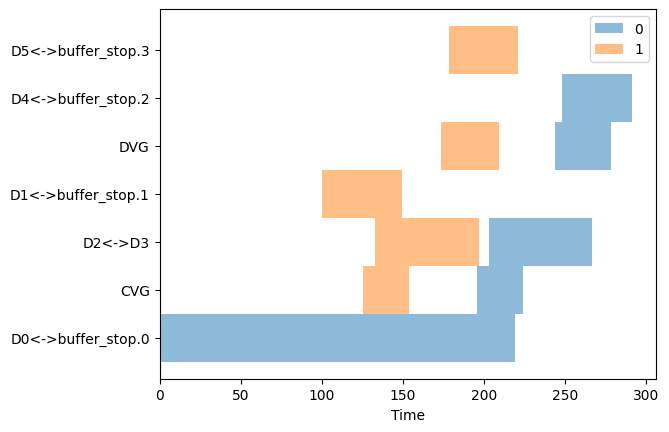

In [18]:
agent = AddStop('addstop', train=0, zone='D0<->buffer_stop.0', duration=50.)
agent.set_schedules_from_osrd(sim)

agent.initial_schedule.plot()
agent.delayed_schedule.plot()
agent.regulated_schedule.plot()
